#### By: Peyman Shahidi
#### Created: Oct 19, 2025
#### Last Edit: Dec 15, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
import subprocess
import os


# Install caffeinate package
%pip install caffeinate

# Use macOS built-in caffeinate command for reliability
# This prevents the system from sleeping while the process is running
try:
    # Start caffeinate in the background
    caff_process = subprocess.Popen(['caffeinate', '-d'], 
                                   stdout=subprocess.DEVNULL, 
                                   stderr=subprocess.DEVNULL)
    print(f"Caffeinate mode ON ☕ – Device will stay awake (PID: {caff_process.pid})")
    print("System sleep is disabled while this process runs.")
    
    # Store the process ID for later cleanup
    caff_pid = caff_process.pid
    
except Exception as e:
    print(f"⚠️ Could not start caffeinate: {e}")
    print("Continuing without caffeinate - system may sleep during long processes.")
    caff_process = None
    caff_pid = None

Note: you may need to restart the kernel to use updated packages.
Caffeinate mode ON ☕ – Device will stay awake (PID: 73035)
System sleep is disabled while this process runs.


## Set variables

In [3]:
# dependent_var = 'is_ai'
# plot_title_variable = 'Task is AI'
dependent_var = 'is_automated'
plot_title_variable = 'Task is Automated'

KEEP_RANDOM_DWAS = True

In [4]:
# Number of reshuffles
n_shuffles = 1000

TARGET_REGS = ['prev2_is_ai', 'prev_is_ai', 'next_is_ai', 'next2_is_ai']
SPECS = ['no_fe_no_dwa', 'major_fe_no_dwa', 'minor_fe_no_dwa', 'no_fe_with_dwa']#, 'major_fe_with_dwa']
PLOT_TITLES = ['Task Before Previous Task', 'Previous Task', 'Next Task', 'Task After Next Task']

# Labels to match desired output format
VAR_LABELS = {
    'prev2_is_ai': '($t-2$) Task AI',
    'prev_is_ai': '($t-1$) Task AI',
    'next_is_ai': '($t+1$) Task AI',
    'next2_is_ai': '($t+2$) Task AI'
}

In [5]:
path_suffix = "" if KEEP_RANDOM_DWAS else "_noTasksWithRepetitiveDWAs"

main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects/execTypeVaryingDWA_anthropicIndex{path_suffix}'
output_plot_path = f"{main_folder_path}/writeup/plots/execTypeVaryingDWA{path_suffix}"

In [6]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

### Main Code

In [7]:
# Get list of DWAs with tasks in multiple occupations
dwa_list_path = f"{input_data_path}/computed_objects/similar_dwa_tasks/similarTasks"

# Read all CSV files
import glob
dwa_csv_files = glob.glob(os.path.join(dwa_list_path, "*.csv"))
print(f"Found {len(dwa_csv_files)} DWA CSV files.")

# Load them into DataFrames, skipping 1-row files
dwa_dfs = []
skipped_files_count = 0
for f in dwa_csv_files:
    df = pd.read_csv(f)
    if len(df) > 1: # Skip if DWA contains only one task
        dwa_dfs.append(df)
    else:
        skipped_files_count += 1
print(f"Skipped {skipped_files_count} DWA files with only one task.")
    

# Combine into one DataFrame
df_all = pd.concat(dwa_dfs, ignore_index=True)
repetitive_dwa_task_ids = df_all['Task ID'].unique().tolist()
repetitive_dwa_task_titles = df_all['Task Title'].unique().tolist()
print(f"Found {len(repetitive_dwa_task_ids)} tasks related to these DWAs.")

Found 2047 DWA CSV files.
Skipped 47 DWA files with only one task.
Found 13535 tasks related to these DWAs.


In [8]:
# Create dataframe with all tasks that have survived the DWA task similarity procedure
survived_tasks_count_df = df_all.groupby('DWA ID')['Task ID'].nunique().reset_index(name='num_tasks_survived')
survived_tasks_count_df

,DWA ID,num_tasks_survived
0,4.A.1.a.1.I01.D01,3
1,4.A.1.a.1.I01.D02,2
2,4.A.1.a.1.I01.D03,2
3,4.A.1.a.1.I01.D04,7
4,4.A.1.a.1.I02.D01,4
...,...,...
1995,4.A.4.c.3.I07.D01,9
1996,4.A.4.c.3.I07.D02,4
1997,4.A.4.c.3.I07.D03,10
1998,4.A.4.c.3.I07.D04,19


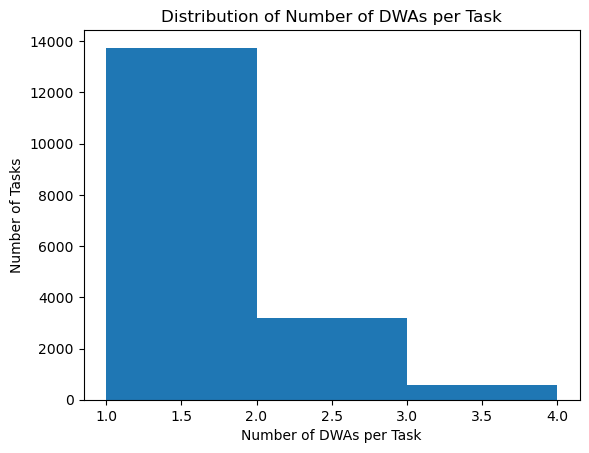

In [9]:
# Get count of how many DWAs each task is mapped to
dwa_task_mapping = pd.read_csv(f"{input_data_path}/computed_objects/similar_dwa_tasks/dwa_task_mapping.csv")
dwa_task_counts = dwa_task_mapping.groupby('Task ID')['DWA ID'].nunique().reset_index(name='num_dwas_per_task')

# Plot distribution of number of DWAs per task
dwa_task_counts = dwa_task_counts.sort_values(by='num_dwas_per_task', ascending=False)
plt.hist(dwa_task_counts['num_dwas_per_task'], bins=range(1, dwa_task_counts['num_dwas_per_task'].max()+2))
plt.xlabel('Number of DWAs per Task')
plt.ylabel('Number of Tasks')
plt.title('Distribution of Number of DWAs per Task')
# plt.savefig(f"{output_plot_path}/dwa_task_count_distribution.png")



# One way of handling multiple-DWA tasks is to only keep those with a single DWA and drop the rest
# Another way is to pick a random DWA for each task
if KEEP_RANDOM_DWAS:
    unique_task_dwa_mapping = (
        dwa_task_mapping
        .groupby("Task ID", group_keys=False)
        .apply(lambda g: g.sample(n=1, random_state=123))
        .reset_index(drop=True)
        )['Task ID'].tolist()
else:
    unique_task_dwa_mapping = dwa_task_counts[dwa_task_counts['num_dwas_per_task'] == 1]['Task ID'].tolist()

In [10]:
# Create a DWA-level dataset with number of tasks and occupations per DWA, as well as fraction of manual, automation, and augmentation tasks per DWA
merged_data = pd.read_csv(f"{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT/ONET_Eloundou_Anthropic_GPT.csv")
merged_data['is_manual'] = merged_data['label'] == 'Manual'
merged_data['is_automation'] = merged_data['label'] == 'Automation'
merged_data['is_augmentation'] = merged_data['label'] == 'Augmentation'


# Merge back DWA ID and DWA Titles to the merged_data
dwa_task_mapping = pd.read_csv(f"{input_data_path}/computed_objects/similar_dwa_tasks/dwa_task_mapping.csv")
print(f'Length of merged_data before merging DWA info: {merged_data.shape[0]}')
merged_data = merged_data.merge(dwa_task_mapping, on=['Task ID', 'Task Title', 'O*NET-SOC Code', 'Occupation Title'], how='left')
print(f'Length of merged_data after merging DWA info: {merged_data.shape[0]}')


# Aggregate to get fractions
dwa_grouped = merged_data.groupby(['DWA ID', 'DWA Title']).agg(
    num_tasks = ('Task ID', 'nunique'),
    num_occupations = ('O*NET-SOC Code', 'nunique'),
    fraction_manual = ('is_manual', 'mean'),
    fraction_automation = ('is_automation', 'mean'),
    fraction_augmentation = ('is_augmentation', 'mean'),
).reset_index()
print(f"Created DWA-level dataset with {dwa_grouped.shape[0]} DWAs.")

# Keep only DWAs with variation in terms of execution type across occupations
dwa_grouped_filtered = dwa_grouped[
     (dwa_grouped['num_occupations'] > 1) & (dwa_grouped['fraction_manual'] > 0) & (dwa_grouped['fraction_manual'] < 1)
].copy()
display(dwa_grouped_filtered)

# Create list of DWAs with varying execution types
dwas_varying_exec_types_ids = dwa_grouped_filtered['DWA ID'].unique().tolist()
dwas_varying_exec_types_titles = dwa_grouped_filtered['DWA Title'].unique().tolist()
print(f"Identified {len(dwas_varying_exec_types_ids)} DWAs with varying execution types across occupations.")

# Merge back the number of tasks survived info
dwa_grouped_filtered = dwa_grouped_filtered.merge(survived_tasks_count_df, left_on='DWA ID', right_on='DWA ID', how='left')

# Save output
dwa_grouped_filtered.to_csv(f"{output_data_path}/dwas_varying_execution_types.csv", index=False)

Length of merged_data before merging DWA info: 17925
Length of merged_data after merging DWA info: 22267
Created DWA-level dataset with 2081 DWAs.


,DWA ID,DWA Title,num_tasks,num_occupations,fraction_manual,fraction_automation,fraction_augmentation
0,4.A.1.a.1.I01.D01,Review art or design materials.,6,4,0.83,0.00,0.17
2,4.A.1.a.1.I01.D03,Review production information to determine cos...,6,2,0.83,0.00,0.17
3,4.A.1.a.1.I01.D04,Study scripts to determine project requirements.,9,8,0.33,0.56,0.11
4,4.A.1.a.1.I02.D01,Read materials to determine needed actions.,4,4,0.75,0.25,0.00
5,4.A.1.a.1.I02.D02,Read maps to determine routes.,4,4,0.75,0.00,0.25
...,...,...,...,...,...,...,...
2066,4.A.4.c.3.I05.D03,"Purchase materials, equipment, or other resour...",22,20,0.95,0.00,0.05
2069,4.A.4.c.3.I05.D06,Purchase products or services.,15,10,0.93,0.07,0.00
2072,4.A.4.c.3.I06.D01,Prescribe treatments or therapies.,19,16,0.89,0.00,0.11
2074,4.A.4.c.3.I06.D03,Prescribe medications.,31,26,0.97,0.00,0.03


Identified 831 DWAs with varying execution types across occupations.


In [11]:
# Read the merged data
merged_data = pd.read_csv(f"{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT/ONET_Eloundou_Anthropic_GPT.csv")
merged_data = merged_data[['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title',
       'Task Position', 'Task Type', 
       'Major_Group_Code', 'Major_Group_Title', 
       'Minor_Group_Code', 'Minor_Group_Title',
       'Broad_Occupation_Code', 'Broad_Occupation_Title',
       'Detailed_Occupation_Code', 'Detailed_Occupation_Title',
       'gpt4_exposure', 'human_labels', 
       'automation', 'augmentation', 'label']]


# Create is_ai and is_automated flags in merged_data
merged_data['is_ai'] = merged_data['label'].isin(['Augmentation','Automation']).astype(int)
merged_data['is_automated'] = merged_data['label'].isin(['Automation']).astype(int)
merged_data['is_exposed'] = merged_data['human_labels'].isin(['E1']).astype(int)


# Step 1: Add occupation's number of tasks info
num_tasks_per_occupation = merged_data.groupby('O*NET-SOC Code')['Task ID'].nunique().reset_index()
num_tasks_per_occupation = num_tasks_per_occupation.rename(columns={'Task ID': 'num_tasks'})
merged_data = merged_data.merge(num_tasks_per_occupation, on='O*NET-SOC Code', how='left')


# Step 2: Create flags for previous/next tasks is AI within occupation groups
# Sort by occupation and position when possible
merged_data['Task Position'] = pd.to_numeric(merged_data['Task Position'], errors='coerce')
merged_data = merged_data.sort_values(['O*NET-SOC Code', 'Task Position']).reset_index(drop=True)
group_col = 'O*NET-SOC Code'

# Compute neighbor flags (prev/next) within occupation groups when possible
merged_data['prev_is_ai'] = 0
merged_data['prev2_is_ai'] = 0
merged_data['next_is_ai'] = 0
merged_data['next2_is_ai'] = 0
pos_col = 'Task Position'

def add_neighbor_flags(df):
    df = df.copy()
    df['Task Position'] = pd.to_numeric(df['Task Position'], errors='coerce')
    df = df.sort_values(['O*NET-SOC Code','Task Position']).reset_index(drop=True)
    
    def _add_flags(g):
        g = g.sort_values('Task Position')
        # Don't fill NAs - leave them as NaN
        g['prev_is_ai'] = g['is_ai'].shift(1)
        g['prev2_is_ai'] = g['is_ai'].shift(2)
        g['next_is_ai'] = g['is_ai'].shift(-1)
        g['next2_is_ai'] = g['is_ai'].shift(-2)
        return g
    
    return df.groupby('O*NET-SOC Code', group_keys=False).apply(_add_flags).reset_index(drop=True)

# Apply the function
merged_data = merged_data.groupby(group_col, group_keys=False).apply(add_neighbor_flags).reset_index(drop=True)

# Drop rows where ANY neighbor flag is NA
neighbor_cols = ['prev_is_ai', 'prev2_is_ai', 'next_is_ai', 'next2_is_ai']
merged_data = merged_data.dropna(subset=neighbor_cols).reset_index(drop=True)

# Convert to int after dropping NAs
for col in neighbor_cols:
    merged_data[col] = merged_data[col].astype(int)



# Step 3: Add back DWA info
# Merge back DWA ID and DWA Titles to the merged_data
dwa_task_mapping = pd.read_csv(f"{input_data_path}/computed_objects/similar_dwa_tasks/dwa_task_mapping.csv")
merged_data = merged_data.merge(dwa_task_mapping, on=['Task ID', 'Task Title', 'O*NET-SOC Code', 'Occupation Title'], how='left')
# Note that the merge might map multiple DWAs to the same task



# Step 4: Some cleanings
# Filter 0: Remove tasks mapped to more than 1 DWA and remove duplicates in terms of (O*NET-SOC Code, Task ID) if any
print(f'Length of merged_data before removing tasks mapped to multiple DWAs: {merged_data.shape[0]}')
merged_data = merged_data[merged_data['Task ID'].isin(unique_task_dwa_mapping)].reset_index(drop=True)
print(f'Length of merged_data after removing tasks mapped to multiple DWAs: {merged_data.shape[0]}\n')

print(f'Length of merged_data before dropping duplicates: {merged_data.shape[0]}')
merged_data = merged_data.drop_duplicates(subset=['O*NET-SOC Code', 'Task ID']).reset_index(drop=True)
print(f'Length of merged_data after dropping duplicates: {merged_data.shape[0]}\n')

# Filter 1: Remove tasks without any DWA info
print(f'Length of merged_data before removing tasks without DWA info: {merged_data.shape[0]}')
print(f'Number of tasks without DWA info: {merged_data[merged_data["DWA ID"].isna()].shape[0]}')
merged_data = merged_data[~merged_data['DWA ID'].isna()].reset_index(drop=True)
print(f'Length of merged_data after removing tasks without DWA info: {merged_data.shape[0]}\n')

# Filter 2: Remove DWAs whose tasks appear in only a single occupation
print(f'Length of merged_data before filtering DWAs with tasks in single occupation: {merged_data.shape[0]}')
merged_data = merged_data[~merged_data['DWA ID'].isna()].reset_index(drop=True)
dwa_occupation_counts = merged_data.groupby('DWA ID')['O*NET-SOC Code'].nunique().reset_index()
dwa_occupation_counts = dwa_occupation_counts.rename(columns={'O*NET-SOC Code': 'num_occupations'})
dwas_to_keep = dwa_occupation_counts[dwa_occupation_counts['num_occupations'] > 1]['DWA ID'].unique().tolist()
print(f'Number of Tasks whose DWA contain tasks in a single occupation: {len(merged_data[~merged_data['DWA ID'].isin(dwas_to_keep)])}')
merged_data = merged_data[merged_data['DWA ID'].isin(dwas_to_keep)].reset_index(drop=True)
print(f'Length of merged_data after filtering DWAs with tasks in single occupation: {merged_data.shape[0]}')



# Step 5: Create variable indicating how many tasks are present the task's DWA within the occupation
dwa_occupation_task_counts = merged_data.groupby(['DWA ID', 'O*NET-SOC Code'])['Task ID'].nunique().reset_index(name='num_tasks_in_dwa_within_occupation')
merged_data = merged_data.merge(dwa_occupation_task_counts, on=['DWA ID', 'O*NET-SOC Code'], how='left')


# Get list of tasks present in the final merged_data
merged_data_task_ids = merged_data['Task ID'].unique().tolist()

# Save the cleaned merged_data for future use
merged_data.to_csv(f"{output_data_path}/similarTasks_allEligibleTasks.csv", index=False)

Length of merged_data before removing tasks mapped to multiple DWAs: 17849
Length of merged_data after removing tasks mapped to multiple DWAs: 17524

Length of merged_data before dropping duplicates: 17524
Length of merged_data after dropping duplicates: 14112

Length of merged_data before removing tasks without DWA info: 14112
Number of tasks without DWA info: 0
Length of merged_data after removing tasks without DWA info: 14112

Length of merged_data before filtering DWAs with tasks in single occupation: 14112
Number of Tasks whose DWA contain tasks in a single occupation: 326
Length of merged_data after filtering DWAs with tasks in single occupation: 13786


In [12]:
# Now create different extracts of the data for different ways of handling the repetitive tasks

# # Extract 1: 
# # Remove DWAs that contain occupations with more than one task altogether -- conservative approach with minimal filtering applied to O*NET data
# # Identify DWAs to remove
# dwa_task_occupation_counts = merged_data.groupby(['DWA ID', 'O*NET-SOC Code'])['Task ID'].nunique().reset_index()
# dwa_task_occupation_counts['has_multiple_tasks'] = dwa_task_occupation_counts['Task ID'] > 1
# dwas_to_remove = dwa_task_occupation_counts[dwa_task_occupation_counts['has_multiple_tasks']]['DWA ID'].unique().tolist()
# print(f"Identified {len(dwas_to_remove)} DWAs to remove due to multiple tasks in at least one occupation.")

# original_ONET_ideal_DWAs_data = merged_data[~merged_data['DWA ID'].isin(dwas_to_remove)].reset_index(drop=True)
# print(f"Original O*NET ideal DWAs dataset has {original_ONET_ideal_DWAs_data.shape[0]} tasks across {original_ONET_ideal_DWAs_data['DWA ID'].nunique()} DWAs.\n")

# # Save the original O*NET ideal DWAs dataset
# original_ONET_ideal_DWAs_data.to_csv(f"{output_data_path}/similarTasks_ONEToriginal_idealDWAs.csv", index=False)


# # Extract 2: 
# # Remove the tasks of occupations with multiple tasks within each DWA - less conservative approach as it keeps more observations but removes some tasks within DWAs
# task_counts = merged_data.groupby(['DWA ID', 'O*NET-SOC Code'])['Task ID'].nunique().reset_index()
# task_counts = task_counts.rename(columns={'Task ID': 'num_tasks_in_occupation_in_DWA'})
# merged_data_with_counts = merged_data.merge(task_counts, on=['DWA ID', 'O*NET-SOC Code'], how='left')
# merged_data_without_repetitive_occupation_tasks = merged_data_with_counts[merged_data_with_counts['num_tasks_in_occupation_in_DWA'] == 1].reset_index(drop=True)

# # Now remove DWAs that have only one occupation left after this filtering
# dwa_occupation_counts_after_filter = merged_data_without_repetitive_occupation_tasks.groupby('DWA ID')['O*NET-SOC Code'].nunique().reset_index()
# dwa_occupation_counts_after_filter = dwa_occupation_counts_after_filter.rename(columns={'O*NET-SOC Code': 'num_occupations'})
# dwas_to_keep_after_filter = dwa_occupation_counts_after_filter[dwa_occupation_counts_after_filter['num_occupations'] > 1]['DWA ID'].unique().tolist()
# merged_data_without_repetitive_occupation_tasks = merged_data_without_repetitive_occupation_tasks[merged_data_without_repetitive_occupation_tasks['DWA ID'].isin(dwas_to_keep_after_filter)].reset_index(drop=True)
# print(f"Filtered O*NET ideal DWAs dataset has {merged_data_without_repetitive_occupation_tasks.shape[0]} tasks across {merged_data_without_repetitive_occupation_tasks['DWA ID'].nunique()} DWAs.")

# # Save the filtered dataset without repetitive occupation tasks
# merged_data_without_repetitive_occupation_tasks.to_csv(f"{output_data_path}/similarTasks_onlyKept_uniqueTaskOccupations_withinDWA.csv", index=False)



# Extract 3: 
# Retain only similar tasks within each DWA (and one task per occupation within each DWA), specified by GPT
filtered_data = merged_data[(merged_data['DWA ID'].isin(dwas_varying_exec_types_ids)
                             & 
                             merged_data['Task ID'].isin(repetitive_dwa_task_ids)
                             )
                             ].reset_index(drop=True)
gpt_filtered_task_ids = filtered_data['Task ID'].unique().tolist()

# Save the GPT-filtered dataset
filtered_data.to_csv(f"{output_data_path}/GPT_filtered_DWAs_data.csv", index=False)

## Run regression of multiple-execution-type DWA tasks against execution type of neighboring tasks

In [13]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import norm
from pathlib import Path
import os
from io import StringIO


# ==========================================
# 1. Robust AME Extractor
# ==========================================
def build_ame_df(
    res,
    df_used,
    dataset_name,
    model_name,
    target_regs,
    fe_label,
    dwa_fe,
    formula,
    calculate_standard_errors=True,
    cluster_col="DWA ID",
    B=200,
    seed=123
):
    try:
        np.random.seed(seed)

        pr2 = res.prsquared
        k = res.params.shape[0]
        adj_pr2 = 1 - (res.llf - k) / res.llnull
        nobs = int(res.nobs)

        df_base = df_used.copy()
        df_base.columns = df_base.columns.str.strip()

        # ---------- point estimates ----------
        ame_point = {}
        for var in target_regs:
            if var not in df_base.columns:
                continue

            df1 = df_base.copy()
            df0 = df_base.copy()
            df1[var] = 1
            df0[var] = 0

            p1 = res.predict(df1)
            p0 = res.predict(df0)
            ame_point[var] = np.mean(p1 - p0)

        # ---------- optionally compute SEs ----------
        ame_se = {v: 0.0 for v in ame_point.keys()}
        ame_p = {v: 0.0 for v in ame_point.keys()}

        if calculate_standard_errors:
            if B % 50 == 1:
                print(f"Calculating AME standard errors with B={B} bootstrap samples for model {model_name}...")
            ame_boot = {v: [] for v in ame_point.keys()}
            clusters = df_base[cluster_col].unique()

            for _ in range(B):
                sampled_clusters = np.random.choice(
                    clusters, size=len(clusters), replace=True
                )

                df_b = pd.concat(
                    [df_base[df_base[cluster_col] == c] for c in sampled_clusters],
                    ignore_index=True
                )

                try:
                    res_b = smf.logit(formula, data=df_b).fit(disp=False)

                    for var in ame_point.keys():
                        df1 = df_b.copy()
                        df0 = df_b.copy()
                        df1[var] = 1
                        df0[var] = 0

                        p1 = res_b.predict(df1)
                        p0 = res_b.predict(df0)
                        ame_boot[var].append(np.mean(p1 - p0))

                except Exception:
                    continue

            for var in ame_point.keys():
                if len(ame_boot[var]) > 1:
                    se = np.std(ame_boot[var], ddof=1)
                    z = ame_point[var] / se if se > 0 else 0.0
                    p = 2 * (1 - norm.cdf(abs(z))) if se > 0 else 0.0
                else:
                    se, p = 0.0, 0.0

                ame_se[var] = se
                ame_p[var] = p

        # ---------- assemble ----------
        rows = []
        for var, ame in ame_point.items():
            rows.append({
                "term": var,
                "ame_coef": ame,
                "ame_se": ame_se[var],
                "p_value": ame_p[var]
            })

        ame_df = pd.DataFrame(rows)

        return pd.DataFrame({
            "dataset": dataset_name,
            "model": model_name,
            "fe_label": fe_label,
            "dwa_fe": dwa_fe,
            "nobs": nobs,
            "r2_pseudo": pr2,
            "r2_adj_pseudo": adj_pr2,
            "term": ame_df["term"],
            "ame_coef": ame_df["ame_coef"],
            "ame_se": ame_df["ame_se"],
            "p_value": ame_df["p_value"],
        })

    except Exception as e:
        print(f"Error calculating AME for {model_name}: {e}")
        return pd.DataFrame()



# ==========================================
# 2. Regression Runner
# ==========================================
def filter_on_identifying_variation(
    df, group_cols, regressors, dependent_var, min_unique=2
):
    """
    Keeps only groups where EACH regressor and the dependent variable varies within the group.
    """
    variables_to_check = regressors + [dependent_var]
    def has_variation(g):
        return all(g[r].nunique() >= min_unique for r in variables_to_check)

    return df.groupby(group_cols, group_keys=False).filter(has_variation)


def run_regressions_on(df, dataset_name, dependent_var, regressors, calculate_standard_errors=True):
    df = df.copy()
    all_cols = regressors + [dependent_var, 'is_exposed', 'num_tasks', 'DWA ID']
    existing_cols = [c for c in all_cols if c in df.columns]
    
    # Convert numeric columns but NOT DWA ID (keep it as categorical)
    numeric_cols = [c for c in existing_cols if c != 'DWA ID']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    base_formula = f'{dependent_var} ~ ' + ' + '.join(regressors)
    ame_list = []
    models = {}

    # ==== WITHOUT DWA Fixed Effects ====
    
    # 1) No SOC FE, No DWA FE
    try:
        formula = base_formula + ' + is_exposed + num_tasks'
        res = smf.logit(formula, data=df).fit(
            disp=False, 
            cov_type='cluster',
            cov_kwds={'groups': df['DWA ID'],
                      'use_correction': True}
        )
        models['no_fe_no_dwa'] = res
        ame_list.append(build_ame_df(res, df, dataset_name, 'no_fe_no_dwa', regressors, 
                                     fe_label="None", dwa_fe=False, formula=formula,
                                     calculate_standard_errors=calculate_standard_errors))
        # print(f"[{dataset_name}] No-FE, No-DWA model converged.")
    except Exception as e: 
        print(f"[{dataset_name}] No-FE, No-DWA failed: {e}")

    # 2) Major FE, No DWA FE
    if 'Major_Group_Code' in df.columns:
        try:
            formula = base_formula + ' + C(Major_Group_Code) + is_exposed + num_tasks'
            # keep only the groups with variation in dependent variable
            df_fe_major = df.groupby("Major_Group_Code").filter(lambda g: g[dependent_var].nunique() > 1)
            res = smf.logit(formula, data=df_fe_major).fit(
                disp=False, 
                cov_type='cluster',
                cov_kwds={'groups': df_fe_major['DWA ID'],
                          'use_correction': True}
            )
            models['major_fe_no_dwa'] = res
            ame_list.append(build_ame_df(res, df_fe_major, dataset_name, 'major_fe_no_dwa', regressors, 
                                         fe_label="Major Group", dwa_fe=False, formula=formula,
                                         calculate_standard_errors=calculate_standard_errors))
            # print(f"[{dataset_name}] Major FE, No-DWA model converged.")
        except Exception as e:
            print(f"[{dataset_name}] Major FE, No-DWA failed: {e}")

    # 3) Minor FE, No DWA FE
    if 'Minor_Group_Code' in df.columns:
        try:
            formula = base_formula + ' + C(Minor_Group_Code) + is_exposed + num_tasks'
            # keep only the groups with variation in dependent variable
            df_fe_minor = df.groupby("Minor_Group_Code").filter(lambda g: g[dependent_var].nunique() > 1)
            res = smf.logit(formula, data=df_fe_minor).fit(
                disp=False, 
                cov_type='cluster',
                cov_kwds={'groups': df_fe_minor['DWA ID'],
                          'use_correction': True}
            )
            models['minor_fe_no_dwa'] = res
            ame_list.append(build_ame_df(res, df_fe_minor, dataset_name, 'minor_fe_no_dwa', regressors, 
                                         fe_label="Minor Group", dwa_fe=False, formula=formula,
                                         calculate_standard_errors=calculate_standard_errors))
            # print(f"[{dataset_name}] Minor FE, No-DWA model converged.")
        except Exception as e:
            print(f"[{dataset_name}] Minor FE, No-DWA failed: {e}")

    # ==== WITH DWA Fixed Effects ====

    # 4) No SOC FE, With DWA FE
    try:
        formula = base_formula + ' + C(DWA_ID) + is_exposed + num_tasks'
        # Rename column to avoid spaces in formula
        df['DWA_ID'] = df['DWA ID']
        # keep only the groups with variation in dependent variable
        df_dwa = df.groupby("DWA_ID").filter(lambda g: g[dependent_var].nunique() > 1)
        res = smf.logit(formula, data=df_dwa).fit(
            disp=False, 
            cov_type='cluster',
            cov_kwds={'groups': df_dwa['DWA_ID'],
                      'use_correction': True}
        )
        models['no_fe_with_dwa'] = res
        ame_list.append(build_ame_df(res, df_dwa, dataset_name, 'no_fe_with_dwa', regressors, 
                                     fe_label="None", dwa_fe=True, formula=formula,
                                     calculate_standard_errors=calculate_standard_errors))
        # print(f"[{dataset_name}] No-FE, With-DWA model converged.")
    except Exception as e: 
        print(f"[{dataset_name}] No-FE, With-DWA failed: {e}")


    # 5) No SOC FE, No DWA FE, With Same DWA Task Counts in Occupation
    try:
        formula = base_formula + ' + is_exposed + num_tasks + num_tasks_in_dwa_within_occupation'
        # Rename column to avoid spaces in formula
        df['DWA_ID'] = df['DWA ID']
        res = smf.logit(formula, data=df_dwa).fit(
            disp=False, 
            cov_type='cluster',
            cov_kwds={'groups': df_dwa['DWA_ID'],
                      'use_correction': True}
        )
        models['no_fe_no_dwa_withTaskDWACount'] = res
        ame_list.append(build_ame_df(res, df_dwa, dataset_name, 'no_fe_no_dwa_withTaskDWACount', regressors, 
                                     fe_label="None", dwa_fe=False, formula=formula,
                                     calculate_standard_errors=calculate_standard_errors))
        # print(f"[{dataset_name}] No-FE, With-DWA model converged.")
    except Exception as e: 
        print(f"[{dataset_name}] No-FE, With-DWA failed: {e}")

    
    # 6) No SOC FE, With DWA FE, With Same DWA Task Counts in Occupation
    try:
        formula = base_formula + ' + C(DWA_ID) + is_exposed + num_tasks + num_tasks_in_dwa_within_occupation'
        # Rename column to avoid spaces in formula
        df['DWA_ID'] = df['DWA ID']
        # keep only the groups with variation in dependent variable
        df_dwa = df.groupby("DWA_ID").filter(lambda g: g[dependent_var].nunique() > 1)
        res = smf.logit(formula, data=df_dwa).fit(
            disp=False, 
            cov_type='cluster',
            cov_kwds={'groups': df_dwa['DWA_ID'],
                      'use_correction': True}
        )
        models['no_fe_with_dwa_withTaskDWACount'] = res
        ame_list.append(build_ame_df(res, df_dwa, dataset_name, 'no_fe_with_dwa_withTaskDWACount', regressors, 
                                     fe_label="None", dwa_fe=True, formula=formula,
                                     calculate_standard_errors=calculate_standard_errors))
        # print(f"[{dataset_name}] No-FE, With-DWA model converged.")
    except Exception as e: 
        print(f"[{dataset_name}] No-FE, With-DWA failed: {e}")


    # Combine results
    combined = pd.concat(ame_list, ignore_index=True) if ame_list else pd.DataFrame()

    # Save results to CSV
    out_path = f'{output_data_path}/regression_summaries_{dependent_var}'
    os.makedirs(out_path, exist_ok=True)
    combined.to_csv(f'{out_path}/regression_ame_results_{dataset_name}.csv', index=False)

    return models, combined

# ==========================================
# 3. LaTeX Table Generator (MODIFIED FOR 6 COLUMNS)
# ==========================================
from io import StringIO

def generate_latex_table(df_results, regression_table_name):
    if df_results.empty:
        raise ValueError("The input DataFrame is empty. Cannot generate LaTeX table.")

    buf = StringIO()
    w = lambda s: buf.write(s + "\n")

    # Filter for one dataset
    dataset_to_show = df_results['dataset'].unique()[0]
    subset = df_results[df_results['dataset'] == dataset_to_show].copy()

    w(f"% --- LaTeX Table for {dataset_to_show} ---")

    # --- Formatting ---
    def fmt(row):
        stars = ""
        p = row['p_value']
        if pd.notna(p):
            if p < 0.01: stars = "***"
            elif p < 0.05: stars = "**"
            elif p < 0.10: stars = "*"
        return f"{row['ame_coef']:.2f}{stars}", f"({row['ame_se']:.2f})"

    formatted = subset.apply(fmt, axis=1, result_type='expand')
    subset['coef_str'] = formatted[0]
    subset['se_str'] = formatted[1]

    # Pivot
    pivot_coef = subset.pivot(index='term', columns='model', values='coef_str')
    pivot_se = subset.pivot(index='term', columns='model', values='se_str')

    # Ordering
    valid_vars = [v for v in TARGET_REGS if v in pivot_coef.index]
    pivot_coef = pivot_coef.reindex(valid_vars)
    pivot_se = pivot_se.reindex(valid_vars)

    model_order = [
        'no_fe_no_dwa', 'major_fe_no_dwa', 'minor_fe_no_dwa',
        'no_fe_with_dwa',
        'no_fe_no_dwa_withTaskDWACount', 'no_fe_with_dwa_withTaskDWACount'
    ]
    valid_models = [m for m in model_order if m in pivot_coef.columns]

    stats = subset[
        ['model', 'nobs', 'r2_pseudo', 'r2_adj_pseudo', 'fe_label', 'dwa_fe']
    ].drop_duplicates('model').set_index('model')

    # --- LaTeX ---
    col_def = "l" + "c" * len(valid_models)
    w(f"\\begin{{tabular}}{{{col_def}}}")
    w(r"\toprule")

    header_nums = [f"({i+1})" for i in range(len(valid_models))]
    w("Specification & " + " & ".join(header_nums) + r" \\")
    w(r"\midrule")

    # Body
    for var in valid_vars:
        label = VAR_LABELS.get(var, var.replace('_', ' '))
        c_vals = [pivot_coef.loc[var, m] if m in pivot_coef.columns else "" for m in valid_models]
        s_vals = [pivot_se.loc[var, m] if m in pivot_se.columns else "" for m in valid_models]

        w(f"{label} & " + " & ".join(c_vals) + r" \\")
        w(" & " + " & ".join(s_vals) + r" \\")
        w(r"\addlinespace")

    w(r"\midrule")

    # Footer
    w("Pseudo $R^2$ & " + " & ".join(
        f"{stats.loc[m, 'r2_pseudo']:.3f}" if m in stats.index else ""
        for m in valid_models
    ) + r" \\")

    # w("Adj. Pseudo $R^2$ & " + " & ".join(
    #     f"{stats.loc[m, 'r2_adj_pseudo']:.3f}" if m in stats.index else ""
    #     for m in valid_models
    # ) + r" \\")

    w("Observations & " + " & ".join(
        f"{int(stats.loc[m, 'nobs']):,}" if m in stats.index else ""
        for m in valid_models
    ) + r" \\")

    fe_vals = []
    for m in valid_models:
        if m in stats.index:
            label = stats.loc[m, 'fe_label']
            if pd.isna(label) or str(label) == "None":
                fe_vals.append("")
            elif "Major" in str(label):
                fe_vals.append("Major")
            elif "Minor" in str(label):
                fe_vals.append("Minor")
            else:
                fe_vals.append(str(label))
        else:
            fe_vals.append("")
    w("SOC Group FE & " + " & ".join(fe_vals) + r" \\")

    dwa_vals = []
    for m in valid_models:
        if m in stats.index:
            if stats.loc[m, 'dwa_fe']:
                dwa_vals.append("Yes")
            else:
                dwa_vals.append("")
        else:
            dwa_vals.append("")
    w("DWA FE & " + " & ".join(dwa_vals) + r" \\")

    num_tasks_in_dwa_within_occupation_vals = []
    for m in valid_models:
        if m in stats.index:
            if "withTaskDWACount" in m:
                num_tasks_in_dwa_within_occupation_vals.append("Yes")
            else:
                num_tasks_in_dwa_within_occupation_vals.append("")
        else:
            num_tasks_in_dwa_within_occupation_vals.append("")

    w("NumTasks in DWA-Occupation Control & " + " & ".join(num_tasks_in_dwa_within_occupation_vals) + r" \\")

    w(r"\bottomrule")
    w(r"\footnotesize{Clustered standard errors in parentheses. *** p$<$0.01, ** p$<$0.05, * p$<$0.1}")
    w(r"\end{tabular}")


    table_text = buf.getvalue()

    out_path = Path(output_data_path) / "tables"
    out_path.mkdir(parents=True, exist_ok=True)

    with open(f"{out_path}/{regression_table_name}", "w") as f:
        f.write(table_text)

In [14]:
# Run regressions and compare results
if not Path(f'{output_data_path}/tables/allTasks_{dependent_var[3:]}.tex').exists():
    print(">>> Running Regressions on All Eligible Tasks...")
    models_full, res_full = run_regressions_on(merged_data, 'full_0', dependent_var, TARGET_REGS)
    generate_latex_table(res_full, f'allTasks_{dependent_var[3:]}.tex')

# print("\n>>> Running Regressions on original ONET DWAs that have the Ideal Setup...")
# models_filt, res_filt = run_regressions_on(original_ONET_ideal_DWAs_data, 'ideal_DWAs', dependent_var, TARGET_REGS)
# generate_latex_table(res_filt)

# print("\n>>> Running Regressions on Filtered data where Tasks in Occupations with Multiple Tasks in DWAs are Filtered Out...")
# models_filt, res_filt = run_regressions_on(merged_data_without_repetitive_occupation_tasks, 'all_DWAs_onlyUniqueTasks', dependent_var, TARGET_REGS)
# generate_latex_table(res_filt)

if not Path(f'{output_data_path}/tables/GPT_{dependent_var[3:]}.tex').exists():
    print("\n>>> Running Regressions on GPT-filtered data...")
    models_filt, res_filt = run_regressions_on(filtered_data, 'filtered_0', dependent_var, TARGET_REGS)
    generate_latex_table(res_filt, f'GPT_{dependent_var[3:]}.tex')

>>> Running Regressions on All Eligible Tasks...


/opt/anaconda3/envs/edsl/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/edsl/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/edsl/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/edsl/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/edsl/lib/python3.12/site-packages/st


>>> Running Regressions on GPT-filtered data...


/opt/anaconda3/envs/edsl/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/edsl/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/edsl/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/edsl/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/edsl/lib/python3.12/site-packages/st

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ======================================================
# 1. Helper: Extract AME directly (No Transformation)
# ======================================================
def results_to_dict(df_results):
    """
    Reads the dataframe output from run_regressions_on and converts
    the 'ame_coef' column into a dictionary structure. Also returns
    'ame_se' values as a separate dict.
    Returns: (coef_dict, se_dict) with structure coef_dict[spec][term]
    """
    coef_out = {spec: {term: np.nan for term in TARGET_REGS} for spec in SPECS}
    se_out = {spec: {term: np.nan for term in TARGET_REGS} for spec in SPECS}
    
    if df_results is None or (hasattr(df_results, 'empty') and df_results.empty):
        return coef_out, se_out

    for _, row in df_results.iterrows():
        spec = row.get('model')
        term = row.get('term')
        if spec in coef_out and term in coef_out[spec]:
            if 'ame_coef' in row and pd.notna(row['ame_coef']):
                coef_out[spec][term] = row['ame_coef']
            if 'ame_se' in row and pd.notna(row['ame_se']):
                se_out[spec][term] = row['ame_se']
    return coef_out, se_out

# Store observed values
obs_dict_full, obs_se_full = results_to_dict(res_full)
obs_dict_filt, obs_se_filt = results_to_dict(res_filt)

# ======================================================
# 2. Reshuffling Loop
# ======================================================
# Prepare containers for reshuffled AMEs
resh_full = {spec: {t: [] for t in TARGET_REGS} for spec in SPECS}
resh_filt = {spec: {t: [] for t in TARGET_REGS} for spec in SPECS}

# Assuming n_shuffles is defined (e.g., 1000)
print(f'Running {n_shuffles} reshuffles to generate Null Distribution of AMEs...')

for i in range(n_shuffles):
    seed = 42 + i
    
    # Use '_ame_summary.csv' to avoid loading old cached raw-coef files
    fname_full = f"{output_data_path}/regression_summaries_{dependent_var}/regression_ame_results_full_{i}.csv"
    fname_filt = f"{output_data_path}/regression_summaries_{dependent_var}/regression_ame_results_filtered_{i}.csv"

    # --- Load or Compute ---
    # if Path(fname_full).exists() and Path(fname_filt).exists():
    if Path(fname_filt).exists():
        # Load existing results (CSV produced by run_regressions_on)
        res_shuf_full = pd.read_csv(fname_full)
        res_shuf_filt = pd.read_csv(fname_filt)
    else:
        # Create Shuffled Data
        df_shuf = merged_data.copy()
        # Shuffle Task Position within O*NET Code
        df_shuf['Task Position'] = df_shuf.groupby('O*NET-SOC Code')['Task Position'].transform(
            lambda x: x.sample(frac=1, random_state=seed).values
        )
        
        # Re-calculate neighbor flags based on shuffled positions
        df_shuf = df_shuf.groupby(group_col, group_keys=False).apply(add_neighbor_flags).reset_index(drop=True)

        # Drop rows where ANY neighbor flag is NA
        neighbor_cols = ['prev_is_ai', 'prev2_is_ai', 'next_is_ai', 'next2_is_ai']
        df_shuf = df_shuf.dropna(subset=neighbor_cols).reset_index(drop=True)

        # Convert to int after dropping NAs
        for col in neighbor_cols:
            df_shuf[col] = df_shuf[col].astype(int)
        
        
        # Run on Full Data
        _, res_shuf_full = run_regressions_on(df_shuf, f'full_{i}', dependent_var=dependent_var, regressors=TARGET_REGS, calculate_standard_errors=False)
        
        # Run on GPT-filtered Data
        df_shuf_filt = df_shuf[
            (df_shuf['DWA ID'].isin(dwas_varying_exec_types_ids)
             & 
             df_shuf['Task ID'].isin(gpt_filtered_task_ids)
            )
            ].reset_index(drop=True)
        _, res_shuf_filt = run_regressions_on(df_shuf_filt, f'filtered_{i}', dependent_var=dependent_var, regressors=TARGET_REGS, calculate_standard_errors=False)
    
    # --- Store Results ---
    d_full, d_full_se = results_to_dict(res_shuf_full)
    d_filt, d_filt_se = results_to_dict(res_shuf_filt)

    # Append to lists
    for spec in SPECS:
        for t in TARGET_REGS:
            resh_full[spec][t].append(d_full[spec][t])
            resh_filt[spec][t].append(d_filt[spec][t])

    if (i+1) % 50 == 0:
        print(f'  Completed {i+1}/{n_shuffles}')

print('Reshuffles complete; Marginal Effects stored in resh_full and resh_filt.')

Running 1000 reshuffles to generate Null Distribution of AMEs...
  Completed 50/1000
  Completed 100/1000
  Completed 150/1000
  Completed 200/1000
  Completed 250/1000
  Completed 300/1000
  Completed 350/1000
  Completed 400/1000
  Completed 450/1000
  Completed 500/1000
  Completed 550/1000
  Completed 600/1000
  Completed 650/1000
  Completed 700/1000
  Completed 750/1000
  Completed 800/1000
  Completed 850/1000
  Completed 900/1000
  Completed 950/1000
  Completed 1000/1000
Reshuffles complete; Marginal Effects stored in resh_full and resh_filt.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os # Ensure os is imported for makedirs

# --- Plotting: distributions of Marginal Effects (AME) ---
def plot_comparison_hist(resh_dict, obs_dict, obs_se_dict, title, out_name, plot_title_variable, bins=30):
    """Create the multi-row comparison histogram and also save each row (spec) as a separate image.

    Args:
        resh_dict: dict of reshuffled AMEs per spec and term
        obs_dict: dict of observed AMEs per spec and term
        obs_se_dict: dict of observed AME standard errors per spec and term
        title: title string to include in saved figures
        out_name: filename for the full multi-row figure
        plot_title_variable: human-readable dependent var name for titles
        bins: histogram bins
    """
    
    # --- 1. Calculate Global Bounds for X-Axis ---
    all_resh_vals = [v 
                     for inner_dict in resh_dict.values()
                     for values_list in inner_dict.values()
                     for v in values_list if not np.isnan(v)]
    
    all_obs_vals = [v 
                    for inner_dict in obs_dict.values()
                    for v in inner_dict.values() if not np.isnan(v)]
    
    total_vals = all_resh_vals + all_obs_vals
    if not total_vals:
        print("Warning: No valid data found to plot.")
        return

    g_min, g_max = min(total_vals), max(total_vals)
    symmetric_bound = max(abs(g_min), abs(g_max))
    span = 2 * symmetric_bound
    if span == 0: span = 0.1
    x_limit_min = -symmetric_bound - (span * 0.01)
    x_limit_max = symmetric_bound + (span * 0.01)

    # --- 2. Setup Plot ---
    colors = [plt.cm.tab10(i % 10) for i in range(len(SPECS))]
    fig, axes = plt.subplots(nrows=len(SPECS), ncols=len(TARGET_REGS), 
                             figsize=(6*len(TARGET_REGS), 5*len(SPECS)), 
                             sharey='col')

    if len(SPECS) == 1:
        axes = np.array([axes])

    for r, spec in enumerate(SPECS):
        color_row = colors[r]
        for c, term in enumerate(TARGET_REGS):
            ax = axes[r, c]
            vals = np.array(resh_dict[spec][term], dtype=float)
            vals_clean = vals[~np.isnan(vals)]

            if len(vals_clean):
                # # Shade reshuffle 95% CI behind the histogram
                # lo, hi = np.percentile(vals_clean, [2.5, 97.5])
                # # Clip to x-limits
                # lo = max(lo, x_limit_min)
                # hi = min(hi, x_limit_max)
                # if hi <= lo:
                #     eps = 1e-8 if abs(lo) > 0 else 1e-4
                #     lo, hi = lo - eps, hi + eps
                # ax.axvspan(lo, hi, color=color_row, alpha=0.12, zorder=0)

                # Draw histogram on top of the shaded CI
                ax.hist(vals_clean, bins=bins, color=color_row, alpha=0.7, edgecolor='k', label='Task Position Reshuffled AMEs', zorder=2)
            else:
                ax.text(0.5, 0.5, 'no estimates', ha='center', va='center')

            # Observed AME (red dashed) and ±1.645*SE (vertical lines/shade)
            obs_val = obs_dict.get(spec, {}).get(term, np.nan)
            if not np.isnan(obs_val):
                obs_se = obs_se_dict.get(spec, {}).get(term, np.nan)
                if not np.isnan(obs_se):
                    se_band = 1.645 * obs_se
                    # Shade observed SE band slightly above histogram but under the observed line
                    ax.axvspan(obs_val - se_band, obs_val + se_band, color='red', alpha=0.08, zorder=1)
                    # Also draw thin boundary lines for the observed SE band
                    ax.axvline(obs_val - se_band, color='red', linestyle='--', linewidth=1, alpha=0.9, zorder=3)
                    ax.axvline(obs_val + se_band, color='red', linestyle='--', linewidth=1, alpha=0.9, zorder=3)
                # Observed center line on top
                ax.axvline(obs_val, color='red', linestyle='--', linewidth=3, label=f'Observed = {obs_val:.3f}', zorder=4)

            # Baseline (No Effect) set to 0
            ax.axvline(0.0, color='black', linestyle='-', linewidth=1.5, alpha=0.5, zorder=4)

            # Titles and Labels
            if r == 0:
                clean_title = VAR_LABELS.get(term, term) if 'VAR_LABELS' in globals() else PLOT_TITLES[c]
                ax.set_title(clean_title, fontsize=15, fontweight='bold')
            if r == len(SPECS) - 1:
                ax.set_xlabel('Average Marginal Effect', fontsize=15)
            if c == 0:
                clean_spec = spec.replace('fe_', '').replace('_', ' ').title()
                ax.set_ylabel(f'{clean_spec}\nCount', fontsize=15)

            # Apply consistent X-limits and grid
            ax.set_xlim(x_limit_min, x_limit_max)
            ax.grid(axis='y', linestyle=':', alpha=0.5)
            ax.legend(loc='best', fontsize=10)

    fig.tight_layout()

    # Ensure output dir exists
    Path(output_plot_path).mkdir(parents=True, exist_ok=True)
    out_dir = f'{output_plot_path}/{dependent_var}'
    os.makedirs(out_dir, exist_ok=True)
    out_path = f'{out_dir}/{out_name}'
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    print('Saved full multi-row plot to', out_path)

    # --- 3. Save Individual Rows ---
    base_name = out_name.rsplit('.', 1)[0]
    for r, spec in enumerate(SPECS):
        fig_row, axs_row = plt.subplots(nrows=1, ncols=len(TARGET_REGS), figsize=(24, 5), sharey=False)
        if len(TARGET_REGS) == 1: axs_row = [axs_row]
        color_row = colors[r]
        for c, term in enumerate(TARGET_REGS):
            axr = axs_row[c]
            vals = np.array(resh_dict[spec][term], dtype=float)
            vals_clean = vals[~np.isnan(vals)]

            if len(vals_clean):
                # lo, hi = np.percentile(vals_clean, [2.5, 97.5])
                # lo = max(lo, x_limit_min)
                # hi = min(hi, x_limit_max)
                # if hi <= lo:
                #     eps = 1e-8 if abs(lo) > 0 else 1e-4
                #     lo, hi = lo - eps, hi + eps
                # axr.axvspan(lo, hi, color=color_row, alpha=0.12, zorder=0)
                axr.hist(vals_clean, bins=bins, color=color_row, alpha=0.7, edgecolor='k', label='Task Position Reshuffled AMEs', zorder=2)
            else:
                axr.text(0.5, 0.5, 'no estimates', ha='center', va='center')

            obs_val = obs_dict.get(spec, {}).get(term, np.nan)
            if not np.isnan(obs_val):
                obs_se = obs_se_dict.get(spec, {}).get(term, np.nan)
                if not np.isnan(obs_se):
                    se_band = 1.645 * obs_se
                    axr.axvspan(obs_val - se_band, obs_val + se_band, color='red', alpha=0.08, zorder=1)
                    axr.axvline(obs_val - se_band, color='red', linestyle='--', linewidth=1, alpha=0.9, zorder=3)
                    axr.axvline(obs_val + se_band, color='red', linestyle='--', linewidth=1, alpha=0.9, zorder=3)
                axr.axvline(obs_val, color='red', linestyle='--', linewidth=3, label=f'Observed = {obs_val:.3f}', zorder=4)

            # Zero line
            axr.axvline(0.0, color='black', linestyle='-', linewidth=1.5, alpha=0.5, zorder=4)
            clean_title = VAR_LABELS.get(term, term) if 'VAR_LABELS' in globals() else PLOT_TITLES[c]
            axr.set_title(clean_title, fontsize=15)
            if c == 0:
                axr.set_ylabel('Count', fontsize=15)
            axr.grid(axis='y', linestyle=':', alpha=0.5)
            axr.set_xlim(x_limit_min, x_limit_max)
            axr.set_xlabel('Average Marginal Effect', fontsize=15)
            axr.legend(loc='best', fontsize=10)

        fig_row.tight_layout()
        out_path_row = f'{out_dir}/{base_name}_{spec}.png'
        fig_row.savefig(out_path_row, dpi=300, bbox_inches='tight')
        plt.close(fig_row)
        print('Saved row plot to', out_path_row)

    plt.close()

Path(output_plot_path).mkdir(parents=True, exist_ok=True)

plot_comparison_hist(
    resh_full, 
    obs_dict_full, 
    obs_se_full, 
    f'FULL Dataset (n={n_shuffles})', 
    f'AME_full_{dependent_var}.png', 
    plot_title_variable
)


plot_comparison_hist(
    resh_filt, 
    obs_dict_filt, 
    obs_se_filt, 
    f'FILTERED Dataset (n={n_shuffles})', 
    f'AME_filtered_{dependent_var}.png', 
    plot_title_variable
)

print('All done: comparative Marginal Effect histogram figures created.')

Saved full multi-row plot to ../writeup/plots/execTypeVaryingDWA/is_automated/AME_full_is_automated.png
Saved row plot to ../writeup/plots/execTypeVaryingDWA/is_automated/AME_full_is_automated_no_fe_no_dwa.png
Saved row plot to ../writeup/plots/execTypeVaryingDWA/is_automated/AME_full_is_automated_major_fe_no_dwa.png
Saved row plot to ../writeup/plots/execTypeVaryingDWA/is_automated/AME_full_is_automated_minor_fe_no_dwa.png
Saved row plot to ../writeup/plots/execTypeVaryingDWA/is_automated/AME_full_is_automated_no_fe_with_dwa.png
Saved full multi-row plot to ../writeup/plots/execTypeVaryingDWA/is_automated/AME_filtered_is_automated.png
Saved row plot to ../writeup/plots/execTypeVaryingDWA/is_automated/AME_filtered_is_automated_no_fe_no_dwa.png
Saved row plot to ../writeup/plots/execTypeVaryingDWA/is_automated/AME_filtered_is_automated_major_fe_no_dwa.png
Saved row plot to ../writeup/plots/execTypeVaryingDWA/is_automated/AME_filtered_is_automated_minor_fe_no_dwa.png
Saved row plot to ..

In [17]:
# Clean up caffeinate process
try:
    if 'caff_process' in globals() and caff_process is not None:
        caff_process.terminate()
        caff_process.wait()  # Wait for process to terminate
        print("Caffeinate mode OFF 💡 - System sleep is now enabled.")
    else:
        print("Caffeinate was not running or already stopped.")
except Exception as e:
    print(f"Note: {e}")
    print("Caffeinate process may have already ended.")

Caffeinate mode OFF 💡 - System sleep is now enabled.
